In [1]:
import os
import folium
import math

import pandas as pd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

from matplotlib.animation import FuncAnimation
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import Rbf
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# Define the path to the file
source_file = '.\data\ISMAR\DeltaWaterLevel.xlsx'
# Feed the path to pandas excel reader
df_2007 = pd.read_excel(source_file, sheet_name="2007")
df_2008 = pd.read_excel(source_file, sheet_name="2008")
df_2009 = pd.read_excel(source_file, sheet_name="2009")
df_2014 = pd.read_excel(source_file, sheet_name="2014")
# Let us display some basic information
df_2007.info()
# Compile the data into a list
df_list = [("2007 Start", df_2007[["Xcoord", "Ycoord", "WLStart (mamsl)"]]), ("2007 End", df_2007[["Xcoord", "Ycoord", "WLEnd (mamsl)"]]), 
           ("2008 Start", df_2008[["Xcoord", "Ycoord", "WLStart (mamsl)"]]), ("2008 End", df_2008[["Xcoord", "Ycoord", "WLEnd (mamsl)"]]),
           ("2009 Start", df_2009[["Xcoord", "Ycoord", "WLStart (mamsl)"]]), ("2009 End", df_2009[["Xcoord", "Ycoord", "WLEnd (mamsl)"]]),
           ("2014 Start", df_2014[["Xcoord", "Ycoord", "WLStart (mamsl)"]]), ("2014 End", df_2014[["Xcoord", "Ycoord", "WLEnd (mamsl)"]])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Sitename         16 non-null     object        
 1   Ycoord           16 non-null     float64       
 2   Xcoord           16 non-null     float64       
 3   Zcoord           16 non-null     int64         
 4   DateTimeMeas     16 non-null     datetime64[ns]
 5   DeltaWL          16 non-null     float64       
 6   MAR(2008)        0 non-null      float64       
 7   DateStart        16 non-null     datetime64[ns]
 8   WLStart          16 non-null     float64       
 9   DateEnd          16 non-null     datetime64[ns]
 10  WLEnd            16 non-null     float64       
 11  WLStart (mamsl)  16 non-null     float64       
 12  WLEnd (mamsl)    16 non-null     float64       
dtypes: datetime64[ns](3), float64(8), int64(1), object(1)
memory usage: 1.8+ KB


In [3]:
df_2007.describe()

,Ycoord,Xcoord,Zcoord,DateTimeMeas,DeltaWL,MAR(2008),DateStart,WLStart,DateEnd,WLEnd,WLStart (mamsl),WLEnd (mamsl)
count,1.600000e+01,16.000000,16.000000,16,16.000000,0.0,16,16.000000,16,16.000000,16.000000,16.000000
mean,-3.650967e+06,-77080.599950,36.750000,2007-06-01 00:00:00,2.346875,NaN,2007-04-06 06:00:00,13.023125,2007-09-08 19:30:00,10.676250,23.726875,26.073750
min,-3.655720e+06,-81562.614896,29.000000,2007-06-01 00:00:00,0.480000,NaN,2007-01-30 00:00:00,5.270000,2007-07-04 00:00:00,4.100000,16.840000,17.590000
25%,-3.652507e+06,-77884.149620,31.500000,2007-06-01 00:00:00,1.072500,NaN,2007-03-27 12:00:00,9.987500,2007-08-15 00:00:00,6.437500,20.650000,23.787500
50%,-3.651446e+06,-77003.592266,36.500000,2007-06-01 00:00:00,2.795000,NaN,2007-04-05 00:00:00,13.825000,2007-08-28 12:00:00,10.795000,22.960000,25.885000
75%,-3.648705e+06,-75954.708493,41.000000,2007-06-01 00:00:00,3.440000,NaN,2007-05-03 00:00:00,17.177500,2007-09-16 06:00:00,14.497500,24.747500,26.605000
max,-3.646549e+06,-70887.389628,47.000000,2007-06-01 00:00:00,4.050000,NaN,2007-06-06 00:00:00,19.480000,2007-12-13 00:00:00,16.410000,36.520000,37.000000
std,2.770988e+03,2394.298328,5.709641,NaN,1.278779,NaN,NaN,4.844414,NaN,4.387246,5.014912,4.484113


In [4]:
# Get the minimum and maximum values for the colourbar
max_values = [max(df_2007["WLStart (mamsl)"]), max(df_2007["WLEnd (mamsl)"]),
              max(df_2008["WLStart (mamsl)"]), max(df_2008["WLEnd (mamsl)"]),
              max(df_2009["WLStart (mamsl)"]), max(df_2009["WLEnd (mamsl)"]),
              max(df_2014["WLStart (mamsl)"]), max(df_2014["WLEnd (mamsl)"]),]
min_values = [min(df_2007["WLStart (mamsl)"]), min(df_2007["WLEnd (mamsl)"]),
              min(df_2008["WLStart (mamsl)"]), min(df_2008["WLEnd (mamsl)"]),
              min(df_2009["WLStart (mamsl)"]), min(df_2009["WLEnd (mamsl)"]),
              min(df_2014["WLStart (mamsl)"]), min(df_2014["WLEnd (mamsl)"]),]
cbar_levels = np.linspace(min(min_values), max(max_values), 14)

In [5]:
# Grid size
x_size = 2000
y_size = 2000
# Create grid values first.
x_list = np.linspace(-81560, -70890, x_size)
y_list = np.linspace(-3655710, -3646550, y_size)
X_nodes, Y_nodes = np.meshgrid(x_list, y_list)
# Create a dataframe of the values
grid_X = np.meshgrid(x_list, y_list)[1].ravel()
grid_Y = np.meshgrid(x_list, y_list)[0].ravel()
grid_frame = pd.DataFrame({'Xcoord': grid_X, 'Ycoord': grid_Y})

Here we have some basic interpolation functions and a function with which to plot interpolated data:

In [ ]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist
    # Make weights sum to one
    weights /= weights.sum(axis=0)
    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def linear_rbf(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    # Mutual pariwise distances between observations
    internal_dist = distance_matrix(x,y, x,y)
    # Now solve for the weights such that mistfit at the observations is minimized
    weights = np.linalg.solve(internal_dist, z)
    # Multiply the weights for each interpolated point by the distances
    zi =  np.dot(dist.T, weights)
    return zi

def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # From: <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def plot_results(x, y, xi, yi, zi, description: str, name: str):
    fig, ax = plt.subplots()

    cntr = ax.contour(xi, yi, zi, levels=cbar_levels, linewidths=0.5, colors='k')
    cntrf = ax.contourf(xi, yi, zi, levels=cbar_levels, cmap="RdBu_r")
    boreholes = ax.plot(x, y, 'ko', ms=3)

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.set_label("Water Level (mamsl)", rotation=90, labelpad=15)
    cbar.ax.tick_params(labelsize=8)

    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax.set_title(f"{description}")
    ax.set_xlabel("Xcoord (m)")
    ax.set_ylabel("Ycoord (m)")

    plt.tight_layout()
    fig.savefig(f".\output\{name}.png")
    plt.show()

The flatten() function converts a multi-dimensional NumPy array into a one-dimensional array. When it does so it creates a new copy of the data, thus the original array stays unchanged. If your array has rows and columns or even more dimensions, then flatten() lines up every single value into a straight list, one after another.

In [ ]:
X_nodes_flat, Y_nodes_flat = X_nodes.flatten(), Y_nodes.flatten()

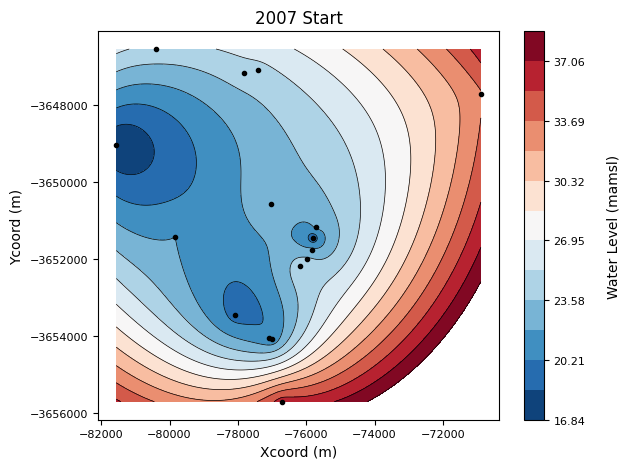

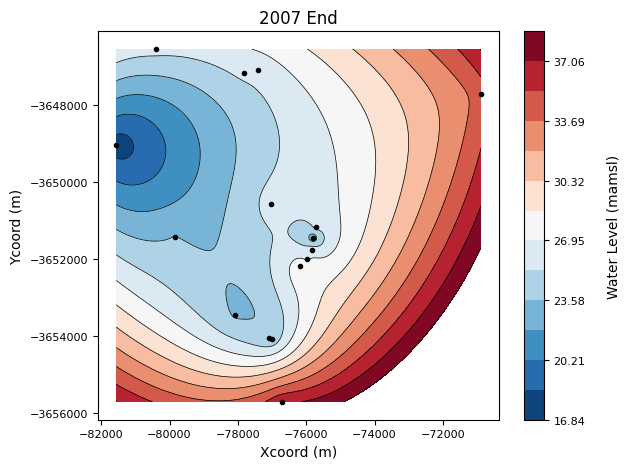

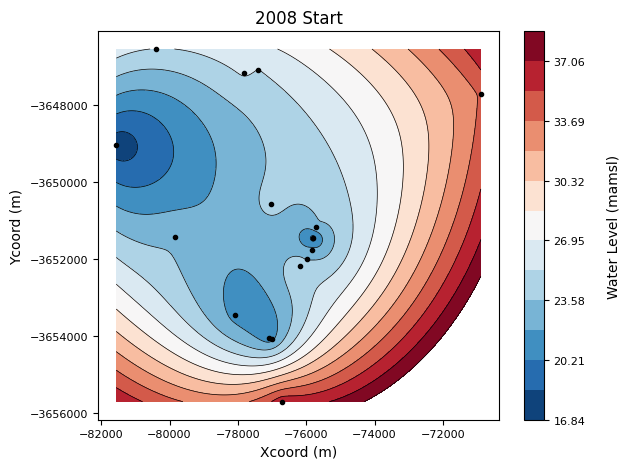

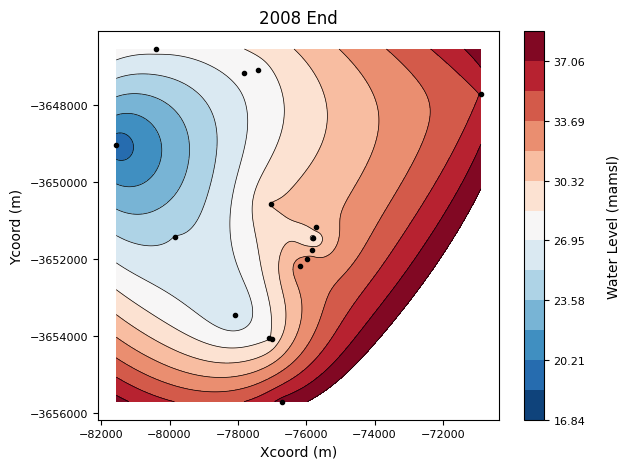

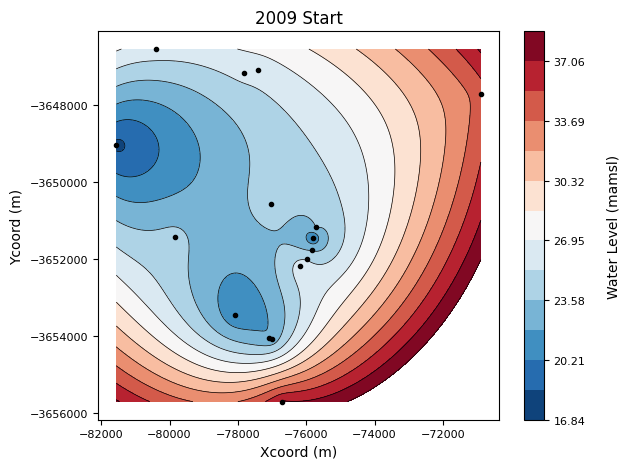

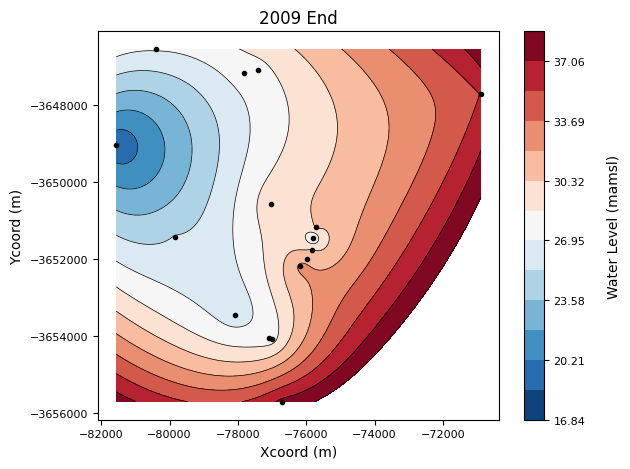

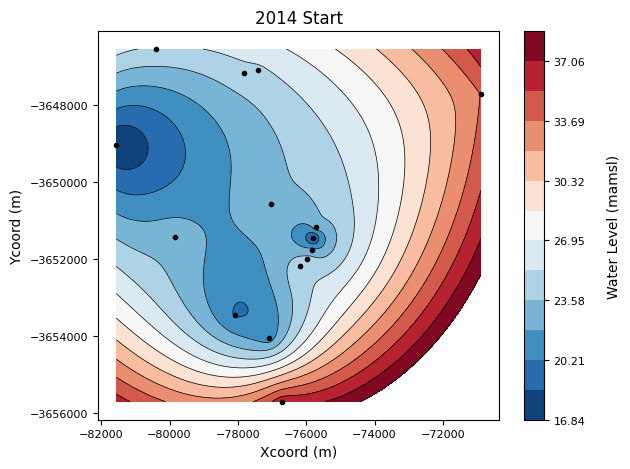

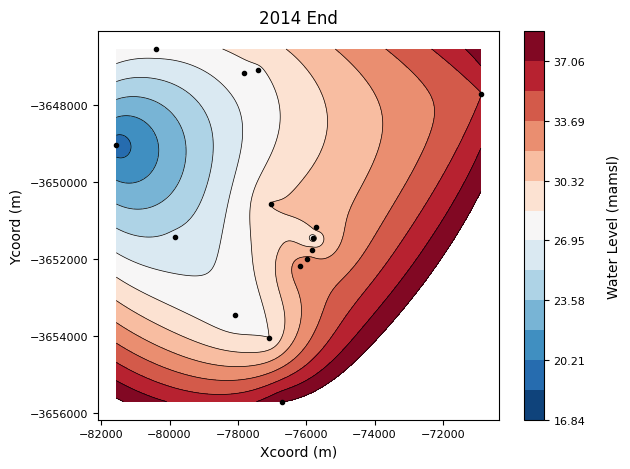

In [ ]:
# Save individual figures for each plot
for label, df_wl in df_list:
    if label.endswith("Start"):
        column_name = "WLStart (mamsl)"
    else:
        column_name = "WLEnd (mamsl)"
    # Interpolate the data using inverse distance weighting
    zi_ind = scipy_idw(x=df_wl["Xcoord"], y=df_wl["Ycoord"], z=df_wl[column_name], xi=X_nodes_flat, yi=Y_nodes_flat)
    zi_ind = zi_ind.reshape((y_size, x_size))
    # Create the image
    plot_results(x=df_wl["Xcoord"], y=df_wl["Ycoord"], xi=X_nodes, yi=Y_nodes, zi=zi_ind, description=label, name=label)

Images are great, but I'm a real fan of animations, let's animate this series of images:

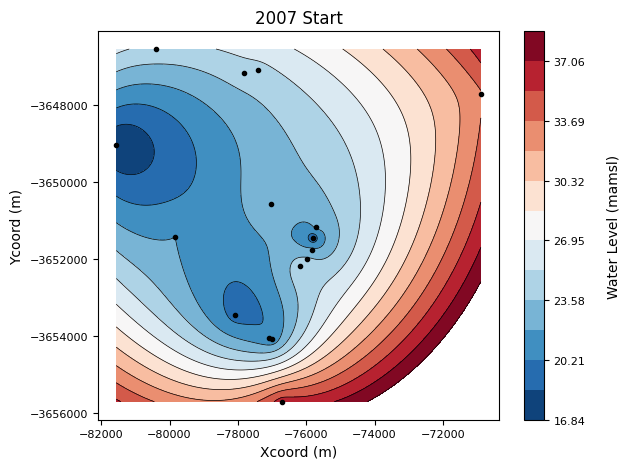

In [ ]:
 # Define the animation function
def animation_function(frame):
    label, df_wl = df_list[frame]

    if label.endswith("Start"):
        column_name = "WLStart (mamsl)"
    else:
        column_name = "WLEnd (mamsl)"

    zi = scipy_idw(x=df_wl["Xcoord"], y=df_wl["Ycoord"], z=df_wl[column_name], xi=X_nodes_flat, yi=Y_nodes_flat)
    zi = zi.reshape((y_size, x_size))

    ax.cla()

    cntr = ax.contour(X_nodes, Y_nodes, zi, levels=cbar_levels, linewidths=0.5, colors='k')
    cntrf = ax.contourf(X_nodes, Y_nodes, zi, levels=cbar_levels, cmap="RdBu_r")
    boreholes = ax.plot(df_wl["Xcoord"], df_wl["Ycoord"], 'ko', ms=3)

    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax.set_title(f"{label}")

    ax.set_xlabel("Xcoord (m)")
    ax.set_ylabel("Ycoord (m)")

# Create the figure
fig, ax = plt.subplots()
# Plot the initial data
zi_Start_2007 = scipy_idw(x=df_2007["Xcoord"], y=df_2007["Ycoord"], z=df_2007["WLStart (mamsl)"], xi=X_nodes_flat, yi=Y_nodes_flat)
zi_Start_2007 = zi_Start_2007.reshape((y_size, x_size))

cntr = ax.contour(X_nodes, Y_nodes, zi_Start_2007, levels=cbar_levels, linewidths=0.5, colors='k')
cntrf = ax.contourf(X_nodes, Y_nodes, zi_Start_2007, levels=cbar_levels, cmap="RdBu_r")
boreholes = ax.plot(df_2007["Xcoord"], df_2007["Ycoord"], 'ko', ms=3)

cbar = fig.colorbar(cntrf, ax=ax)
cbar.set_label("Water Level (mamsl)", rotation=90, labelpad=15)
cbar.ax.tick_params(labelsize=8)

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_title(f"2007 Start")

ax.set_xlabel("Xcoord (m)")
ax.set_ylabel("Ycoord (m)")
plt.tight_layout()

# Create the animation
anim_created = FuncAnimation(fig, animation_function, repeat=True, frames=len(df_list), interval=20)
# Convert the animation using Pillow to a gif
writer = animation.PillowWriter(fps=0.5, metadata=dict(artist='Anton Lukas'), bitrate=1800)
# Save the gif file to disk
anim_created.save(f".\output\water_levels_animated.gif", writer=writer)